In [1]:
# !pip install iteround==1.0.2
# !pip install pairing==0.1.3
# !pip install scikit-multilearn==0.2.0
# !pip install arff==0.9
# !pip install category_encoders==2.1.0
# !pip install matplotlib==3.1.3
# !pip install tensorflow==2.1.0

In [2]:
import sys
sys.path.append("../")
from bandipy import simulation
import numpy as np
## For synthetic data generation
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Using TensorFlow backend.


Before running this code, you first need to run the notebook `1_build_an_encoder` with the desired `context_size` (`d` in the paper).

Thus, if you want to change `context_size` value in the following code, please make sure you have already built the required encoder for it.



> Note: Running the following code takes some minutes, depending on the choosen `users_rng`. e.g. with `users_rng = np.array([1000., 5000., 10000.])`, it takes about 5-10 minutes.

In [3]:
context_size = 10 ## This is `d` in the paper
n_actions = 10 ## This is `A` in the paper
n_samples = 10 ## This is `T` in the paper
early_frac = .70
users_rng = np.array([1e3, 5e3, 1e4, 5e4, 1e5])
## Here we use small number_of_users just for getting fastter results. 
# users_rng = np.array([1000., 5000., 10000.])
n_users_rng = users_rng.copy()
n_users_rng /= early_frac
n_users_rng = n_users_rng.astype(int)
reports = list()

In [0]:

tf.random.set_seed(context_size)

def make_mapping_function(n_inputs, n_outputs):
            mapping_function = Sequential()
            mapping_function.add(Dense(n_outputs,input_dim=n_inputs, activation='linear'))
            mapping_function.compile(loss='categorical_crossentropy', optimizer="sgd")
            return mapping_function
mapping_function = make_mapping_function(context_size,n_actions)
mapping_function.summary()

mapping_function.save_weights("mapping_function.h5")
mapping_function.load_weights("mapping_function.h5")

for n_users in n_users_rng:
    
    print("___________________"+str(n_users)+"_______________________________")
 
    sim = simulation.Simulation(data_type='syn', 
                            bandit_algorithm='contextual_linear_ucb',
                            privacy_model = 'crowd_blending_with_sampling', 
                            sim_sig = 'tmp')

    report = sim.run_simulation(n_users=n_users, early_frac=early_frac, n_samples=n_samples,
                               n_actions=n_actions, context_size=context_size,
                               ctr_scaling_factor=.1,
                               resp_noise_level=.01,
                               mapping_function = mapping_function,
                               alpha =1.,
                               cb_sampling_rate = .5,
                               neg_rew_sam_rate = .05,
                               cb_context_threshold = 10,
                               dec_digits = 1,
                               bin_size = 10)
    reports.append(report)
    np.save("p2b_synthetic_"+str(n_samples)+"_"+str(n_actions)+"_"+str(context_size)+".npy", np.array(reports))
    print("\nResults:\n",np.array(reports)) 
reports = np.array(reports)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________
___________________1428_______________________________
Data Info:
Shapes: (10, 10) (10, 10)
Context_Tail: [[0.07156484 0.09323343 0.01443694 0.15584678 0.12751851 0.05972818
  0.11776145 0.02114212 0.12962169 0.20914606]
 [0.08502069 0.1781206  0.03517463 0.19117568 0.07723762 0.04889069
  0.15653043 0.00536637 0.22123015 0.00125314]]
Response_Tail: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Sum of Responses: [0 0 0 0 0 1 0 0 0 1]

___________________________________________________

0 - *
50 - Dimension of received data at the Server side:
Shapes: (481, 10) (481,) (481,)

___________________________________________________

0 - 
__________

In [4]:
reports = np.load("p2b_synthetic_"+str(n_samples)+"_"+str(n_actions)+"_"+str(context_size)+".npy")
reports.shape

(5, 3, 2)

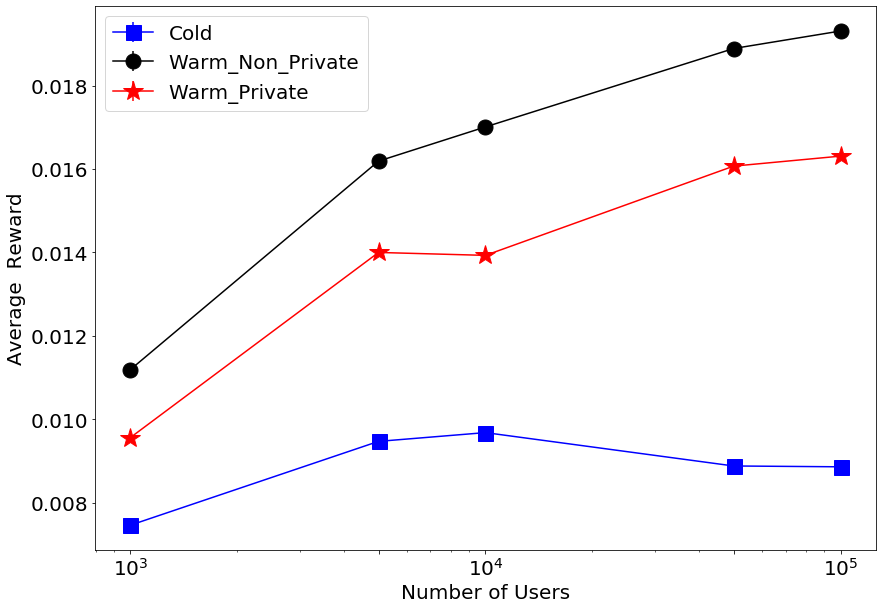

In [6]:
import matplotlib.pyplot as plt
def paint_reports(reports, users_rng):
    x_ax = np.array(users_rng).astype(int)

    fmts = ['bs-', 'ko-', 'r*-']
    plt.errorbar(x_ax, reports[:,0,0], reports[:,0,1]//1, fmt=fmts[0], ms=15, ecolor="blue", label="Cold")
    plt.errorbar(x_ax, reports[:,1,0], reports[:,1,1]//1, fmt=fmts[1], ms=15, ecolor="black", label="Warm_Non_Private")
    plt.errorbar(x_ax, reports[:,2,0], reports[:,2,1]//1, fmt=fmts[2], ms=20, ecolor="red", label="Warm_Private")

users_rng = np.array([1e3, 5e3, 1e4, 5e4, 1e5])

plt.figure(figsize=(14,10))
reports = np.array(reports)
paint_reports(reports, users_rng)
plt.xscale('log')
plt.xlabel('Number of Users', size=20)
plt.ylabel('Average  Reward', size=20)
plt.xticks(users_rng,size=20)
plt.yticks(size=20)
plt.legend( ncol=1, loc='upper left', prop={'size': 20})
plt.show()


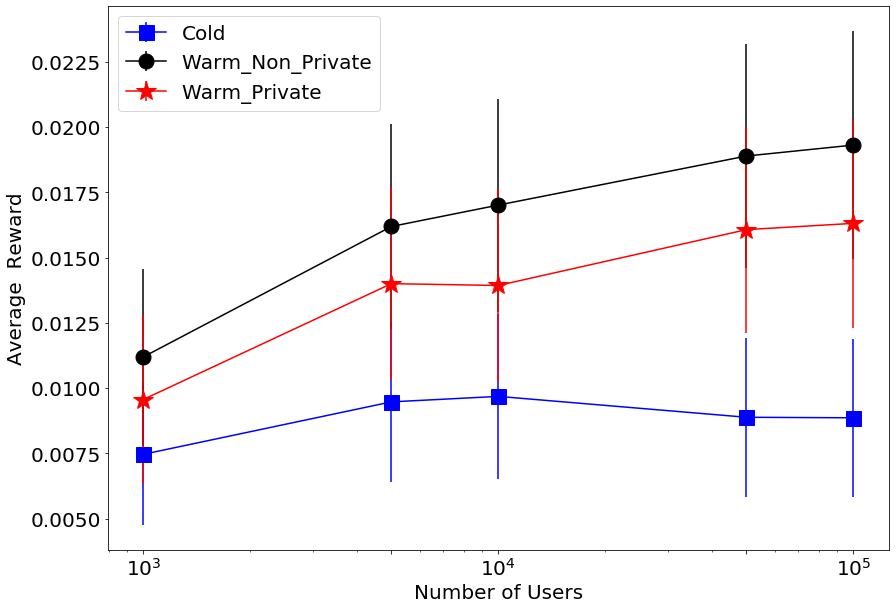

In [7]:
import matplotlib.pyplot as plt
def paint_reports(reports, users_rng):
    x_ax = np.array(users_rng).astype(int)

    fmts = ['bs-', 'ko-', 'r*-']
    plt.errorbar(x_ax, reports[:,0,0], reports[:,0,1]/10, fmt=fmts[0], ms=15, ecolor="blue", label="Cold")
    plt.errorbar(x_ax, reports[:,1,0], reports[:,1,1]/10, fmt=fmts[1], ms=15, ecolor="black", label="Warm_Non_Private")
    plt.errorbar(x_ax, reports[:,2,0], reports[:,2,1]/10, fmt=fmts[2], ms=20, ecolor="red", label="Warm_Private")

users_rng = np.array([1e3, 5e3, 1e4, 5e4, 1e5])

plt.figure(figsize=(14,10))
reports = np.array(reports)
paint_reports(reports, users_rng)
plt.xscale('log')
plt.xlabel('Number of Users', size=20)
plt.ylabel('Average  Reward', size=20)
plt.xticks(users_rng,size=20)
plt.yticks(size=20)
plt.legend( ncol=1, loc='upper left', prop={'size': 20})
plt.show()
